<a href="https://colab.research.google.com/github/coldfir3/KAGGLE-SETI/blob/main/Seti_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Setup

In [ ]:
import sys
import os
is_colab = 'google.colab' in sys.modules

### Downloading data



In [ ]:
if is_colab:

    from google.colab import drive
    from os.path import exists

    if not exists('/content/drive'):
        drive.mount('/content/drive')
    %run '/content/drive/MyDrive/Kaggle/My Kaggle [colab].ipynb'

    if not exists('/content/train/'):
        setup_kaggle()
        get_kaggle_data('d', 'coldfir3/seti-spatial-dataset-v1')
        ! kaggle competitions download -c seti-breakthrough-listen -f train_labels.csv

Mounted at /content/drive
Downloading...
From: https://drive.google.com/uc?id=19H3_BYiHuzIiY9vo9rBsVIu1aSlPlbKx
To: /content/Kaggle/kaggle.json
100% 64.0/64.0 [00:00<00:00, 264kB/s]
drive  Kaggle  sample_data
     |████████████████████████████████| 58 kB 5.5 MB/s 
! kaggle datasets download -d coldfir3/seti-spatial-dataset-v1
100% 11.0G/11.0G [02:33<00:00, 63.6MB/s]
100% 11.0G/11.0G [02:33<00:00, 77.0MB/s]
seti-spatial-dataset-v1.zip



  0% 0.00/522k [00:00<?, ?B/s]
100% 522k/522k [00:00<00:00, 106MB/s]


### Installing packages

In [ ]:
if is_colab:
    !pip install -Uqqq wandb
    !pip install -Uqqq fastai
    !pip install -Uqqq timm

     |████████████████████████████████| 1.6 MB 13.9 MB/s 
     |████████████████████████████████| 170 kB 64.8 MB/s 
     |████████████████████████████████| 133 kB 66.5 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 188 kB 14.3 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 376 kB 14.0 MB/s 


### Loading packages

In [ ]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *
from argparse import Namespace
import timm

## Setting up the DataFrames

In [ ]:
from sklearn.model_selection import StratifiedKFold
if is_colab: 
    base_path = '/content/train/'
    train_df = pd.read_csv('/content/train_labels.csv.zip')
else:
    pass
    # train_study = pd.read_csv('/media/passos/Data/DSET/siim-covid19-detection/train_study_level.csv')

train_df['fold'] = -1
train_df['path'] = train_df['id'].apply(lambda x: base_path + x + '.jpg')
train_df['label'] = train_df['target'].apply(lambda x: 'alien' if x == 1 else 'no-alien')
skf = StratifiedKFold(n_splits = 6, random_state = 42, shuffle = True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df['id'], train_df['target'])):
    train_df.loc[test_index, 'fold'] = fold
train_df

,id,target,fold,path,label
0,0000799a2b2c42d,0,3,/content/train/0000799a2b2c42d.jpg,no-alien
1,00042890562ff68,0,3,/content/train/00042890562ff68.jpg,no-alien
2,0005364cdcb8e5b,0,4,/content/train/0005364cdcb8e5b.jpg,no-alien
3,0007a5a46901c56,0,3,/content/train/0007a5a46901c56.jpg,no-alien
4,0009283e145448e,0,3,/content/train/0009283e145448e.jpg,no-alien
...,...,...,...,...,...
59995,fff8217fe05aba3,0,4,/content/train/fff8217fe05aba3.jpg,no-alien
59996,fffa939e610ed70,0,4,/content/train/fffa939e610ed70.jpg,no-alien
59997,fffbb1c9c3d6c31,1,5,/content/train/fffbb1c9c3d6c31.jpg,alien
59998,fffc9a763d23647,0,0,/content/train/fffc9a763d23647.jpg,no-alien


## DataBlock & DataLoader

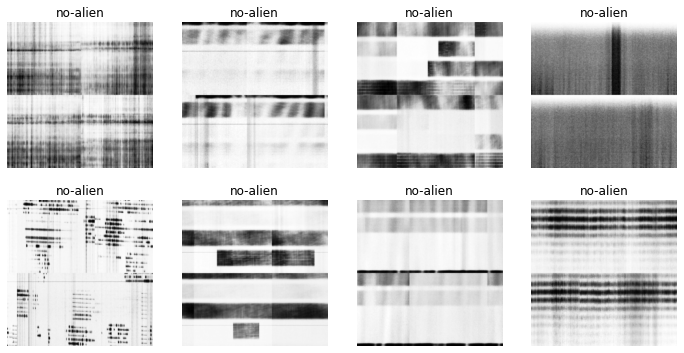

In [ ]:
def get_dls(df, **config):
    is_colab = 'google.colab' in sys.modules
    workers = 2 if is_colab else 10
    splitter = IndexSplitter(df[df.fold == config['fold']].index)
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock()),
        splitter = splitter,
        getters=[ColReader('path'), ColReader('label')],
        item_tfms=Resize(config['img_size']),
        batch_tfms = Flip()#aug_transforms(size = config['img_size'], mult = config['aug'])
        ).dataloaders(df, bs = config['bs'], num_workers = workers)

dls = get_dls(train_df, **{'img_size':224, 'presize':512, 'bs':8, 'fold':0, 'aug':0.1})
dls.show_batch()

In [ ]:
def create_timm_model(**config):

    if config['is_transformer']:
        if config['fastai_head']:
            body = timm.create_model(config['arch'], pretrained=True, num_classes = 0, in_chans = config['in_chans'], img_size = config['img_size'])
            n_features = body(torch.randn((1, config['in_chans'], config['img_size'], config['img_size']))).shape.numel()
            head = create_head(n_features, config['num_classes'], concat_pool = False)
            head = nn.Sequential(*list(head.children())[2:])
            model = nn.Sequential(body, head)
            apply_init(model[1], nn.init.kaiming_normal_)
        else:
            model = timm.create_model(config['arch'], pretrained=True, num_classes = config['num_classes'], in_chans = config['in_chans'], img_size = config['img_size'])
    else:
        if config['fastai_head']:
            body = timm.create_model(config['arch'], pretrained=True, num_classes = 0, in_chans = config['in_chans'])
            body = nn.Sequential(*list(body.children())[:-2])
            head = create_head(num_features_model(body), config['num_classes'], concat_pool=True)
            model = nn.Sequential(body, head)
            apply_init(model[1], nn.init.kaiming_normal_)
        else:
            model = timm.create_model(config['arch'], pretrained=True, num_classes = config['num_classes'], in_chans = config['in_chans'])

    return model

In [ ]:
class SaveAndLogBestModel(SaveModelCallback):

    def __init__(self, mon='valid_loss', **kwargs):
        super().__init__(monitor = mon, fname = mon, **kwargs)

    def _save(self, name): 
        self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)
        self.model_path = Path(*list(self.last_saved_path.parts[:-1])) / (self.fname + '.pth')
        self.metadata = {n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['time']}

    def after_fit(self, **kwargs):
        metadata = self.metadata
        for k,v in metadata.items(): metadata[k] = str(v)
        name = f'run_{wandb.run.id}_model'
        artifact_model = wandb.Artifact(name=name, type='model', metadata=metadata, description='trained model')
        with artifact_model.new_file(name, mode='wb') as fa:
            fa.write(self.model_path.read_bytes())
        wandb.run.log_artifact(artifact_model, aliases = [f'best {self.fname}', f'epoch {metadata["epoch"]}'])

In [ ]:
class wandb_learner():

    def __init__(self, df, **config):

        cbs = []
        if config['Fit']['n_epoch'] < 1:
            df = df.sample(frac=config['Fit']['n_epoch']).reset_index(drop=True)
            config['Fit']['n_epoch'] = 1
            
        self.df = df
        self.config = config

        self.dls = get_dls(df, **config['Dataloader'])
        self.model = create_timm_model(**config['Model'])
        self.learn = Learner(self.dls, self.model, **config['Learner']).add_cbs(cbs)

        self.scheduler = self.config['Fit'].pop('scheduler')
        self.wandb_config = self.config.pop('WandB')

    def unfrozen_count(self):
        return sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, self.model.parameters())])

    def fit(self):

        if self.scheduler == 'fine_tune':

            lr_max  = self.config['Fit'].pop('lr_max')
            n_epoch = self.config['Fit'].pop('n_epoch')
            freeze_lr = self.config['Fit'].pop('freeze_lr')
            freeze_epochs = self.config['Fit'].pop('freeze_epochs')
            lr_mult = self.config['Fit'].pop('lr_mult')
            lr = slice(lr_max/lr_mult, lr_max)

            self.learn.freeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(freeze_epochs, slice(freeze_lr), pct_start=0.99, **self.config['Fit'])

            self.learn.unfreeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(n_epoch - freeze_epochs, lr, pct_start=0.3, div=5.0, **self.config['Fit'])    
            
            self.config['Fit']['lr_max'] = lr_max
            self.config['Fit']['n_epoch'] = n_epoch
            self.config['Fit']['freeze_lr'] = freeze_lr
            self.config['Fit']['freeze_epochs'] = freeze_epochs
            self.config['Fit']['lr_mult'] = lr_mult
            
        elif self.scheduler == 'one_cycle': self.learn.fit_one_cycle(**self.config['Fit'])

        elif self.scheduler == 'cossine': print('not implemented')

        elif self.scheduler == 'reduce_on_plateau': print('not implemented')

        else: self.learn.fit(**self.config['Fit'])

    def wandb_fit(self):
        
        with wandb.init(config = self.config, **self.wandb_config) as run:
            self.learn.add_cb(WandbCallback(log=None, log_preds=False, log_model=False))
            self.learn.add_cb(SaveAndLogBestModel())
            self.fit()

In [ ]:
CFG = {
    'WandB' : {
        'project' : 'Seti V1',
        'tags': ['transformer', 'baseline'],
        'notes':
        """First model, just to check the pipeline
        """,
    },
    'Dataloader' : {
        'img_size' : 384, 
        'bs' : 8,
        'fold' : 0, 
    },
    'Model' : {
        'arch' : 'swin_base_patch4_window12_384',
        'fastai_head' : True,
        'is_transformer' : True,
        'in_chans' : 1, 
        'num_classes' : 2,
        'img_size' : 384, 
    },
    'Learner' : {
        'loss_func' : CrossEntropyLossFlat(),
        'metrics' : RocAucBinary(),
        'cbs' : GradientAccumulation(1024//8),
        'splitter' : default_split
      },
    'Fit' : {
        'scheduler' : 'fine_tune',
        'lr_max' : 1e-3,
        'n_epoch' : 10,
        'freeze_lr' : 2e-3,
        'freeze_epochs' : 2,
        'lr_mult' : 100,
    }
}
 
learn = wandb_learner(train_df, **CFG)
# learn.learn.lr_find()
learn.wandb_fit()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training 585984 parameters ...


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.392028,0.354260,0.496996,54:35
1,0.319185,0.330069,0.544124,54:34


Better model found at epoch 0 with valid_loss value: 0.35426026582717896.
Better model found at epoch 1 with valid_loss value: 0.3300686776638031.
Training 87402872 parameters ...


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.322374,0.293802,0.665050,1:07:45
1,0.293213,0.249562,0.731290,1:07:44
2,0.218478,0.243122,0.750035,1:07:48
3,0.233600,0.231253,0.768038,1:07:48


Better model found at epoch 0 with valid_loss value: 0.2938021421432495.
Better model found at epoch 1 with valid_loss value: 0.24956157803535461.
Better model found at epoch 2 with valid_loss value: 0.24312153458595276.
Better model found at epoch 3 with valid_loss value: 0.23125313222408295.


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.322374,0.293802,0.665050,1:07:45
1,0.293213,0.249562,0.731290,1:07:44
2,0.218478,0.243122,0.750035,1:07:48
3,0.233600,0.231253,0.768038,1:07:48
4,0.242900,0.223765,0.780635,1:07:41


Better model found at epoch 4 with valid_loss value: 0.22376477718353271.


In [ ]:
dls_valid = learn.dls.test_dl()

# Old configs

In [ ]:
CFG = {
    'WandB' : {
        'project' : 'Seti V1',
        'tags': ['resnet', 'baseline'],
        'notes':
        """First model, just to check the pipeline
        """,
    },
    'Dataloader' : {
        'img_size' : 384, 
        'presize' : 512,
        'bs' : 32,
        'fold' : 0, 
        'aug' : 0.1,
    },
    'Model' : {
        'arch' : 'resnet50',
        'fastai_head' : True,
        'is_transformer' : False,
        'in_chans' : 1, 
        'num_classes' : 2,
        'img_size' : 384, 
    },
    'Learner' : {
        'loss_func' : CrossEntropyLossFlat(),
        'metrics' : RocAucBinary(),
        'cbs' : GradientAccumulation(32),
        'splitter' : default_split
      },
    'Fit' : {
        'scheduler' : 'one_cycle',
        'n_epoch' : 10,
        'lr_max' : 1e-3,
    }
}